# PyTorch Learning
KurwAI | Cheslaff | 🎄<br>
<img src="https://images.emojiterra.com/google/noto-emoji/unicode-16.0/color/1024px/1f9ab.png" width=5%>
<img src="https://em-content.zobj.net/source/apple/391/red-heart_2764-fe0f.png" width=5%>
<img src="https://static-00.iconduck.com/assets.00/pytorch-icon-1694x2048-jgwjy3ne.png" width=5%>

## Computer Vision libraries in PyTorch

**torchvision** - special library including datasets, models, transformations for cv problems.


In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

torch.__version__, torchvision.__version__

('2.4.1+cu121', '0.19.1+cu121')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),  # from PIL to tensor
    target_transform=None  # We don't need to transform labels
)

# Testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 13888372.95it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 298391.52it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5588815.19it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7681350.76it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
image, label = train_data[0]
# PyTorch accepts channels first by default, but channels last are also supported
# furthermore, channels last perform better
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [9]:
class_names = train_data.classes
class_names  # multiclass classification

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

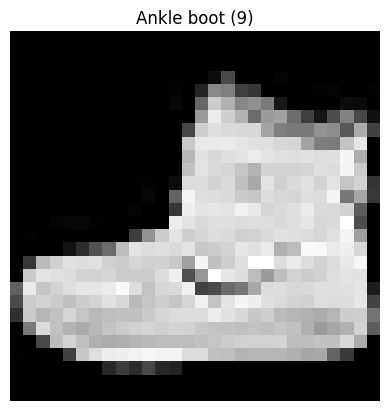

In [17]:
plt.title(f"{class_names[label]} ({label})")
plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray");

## DataLoader

In [18]:
from torch.utils.data import DataLoader

In [23]:
# DataLoader splits data to minibatches
# DataLoaders are iterable
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [24]:
print(f"Train: {len(train_dataloader)} x {BATCH_SIZE}")
print(f"Test: {len(test_dataloader)} x {BATCH_SIZE}")

Train: 1875 x 32
Test: 313 x 32


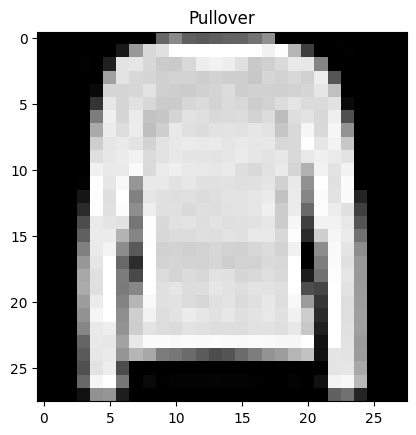

In [54]:
for image_batch, label_batch in train_dataloader:
    image = image_batch[0][0]
    label = label_batch[0].item()
    plt.title(class_names[label])
    plt.imshow(image.squeeze(), cmap="gray")
    break

## Simple BaseLine Model

In [60]:
class DummyModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [61]:
torch.manual_seed(42)

dummy_model = DummyModel(input_shape=784, hidden_units=20, output_shape=len(class_names))
dummy_model.to("cpu")

DummyModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [62]:
def accuracy_fn(y_true, y_pred):
    return 1 / len(y_true) * torch.eq(y_true, y_pred).sum().item()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dummy_model.parameters(), lr=0.1)

In [65]:
torch.manual_seed(42)

epochs=3

for epoch in range(epochs):
    train_loss, train_acc = 0, 0
    for X, y in train_dataloader:
        dummy_model.train()
        y_pred = dummy_model(X)
        loss = loss_fn(y_pred, y.type(torch.LongTensor))
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    test_loss, test_acc = 0, 0
    dummy_model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = dummy_model(X)
            test_loss += loss_fn(test_pred, y.type(torch.LongTensor))
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Test Loss: {test_loss} | Test Acc: {test_acc}")

Epoch: 0 | Train Loss: 0.4543677866458893 | Train Acc: 0.8408333333333333 | Test Loss: 0.47249117493629456 | Test Acc: 0.8343650159744409
Epoch: 1 | Train Loss: 0.444036066532135 | Train Acc: 0.8452 | Test Loss: 0.46863093972206116 | Test Acc: 0.8368610223642172
Epoch: 2 | Train Loss: 0.4358415901660919 | Train Acc: 0.8473333333333334 | Test Loss: 0.4689786434173584 | Test Acc: 0.8379592651757188


In [67]:
torch.manual_seed(42)
def eval_model(model, data_loader, loss_fn, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y.type(torch.LongTensor))
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc
    }

model_results = eval_model(dummy_model, test_dataloader, loss_fn, accuracy_fn)
model_results

{'model_name': 'DummyModel',
 'model_loss': 0.4689786434173584,
 'model_acc': 0.8379592651757188}

**PyTorch Dummy Path 2024-2025**<br>
<img src="https://images.emojiterra.com/google/noto-emoji/unicode-16.0/color/1024px/1f9ab.png" width=5%>
<img src="https://em-content.zobj.net/source/apple/391/red-heart_2764-fe0f.png" width=5%>
<img src="https://static-00.iconduck.com/assets.00/pytorch-icon-1694x2048-jgwjy3ne.png" width=5%><br>
MIT License, no doubt